# BBM 418 & AIN 433 - Computer Vision Laboratory
# Programming Assignment-4: Implementing a Lightweight Object Detector from a Research Paper

**Student Name:** Arda Ceylan

**Student Number:** 2220356041

**Brief Description:** Implementation of a lightweight object detector based on the DETR architecture, adapted for the PennFudanPed dataset. The implementation includes data preprocessing, model architecture, training with Hungarian matching loss, and evaluation metrics.

---

## Overview

This assignment aims to implement a lightweight Tiny-DETR object detection model and evaluate it on the PennFudanPed pedestrian detection dataset. The goal is not just to maximize accuracy, but to understand and reproduce the core ideas of the DETR framework—namely end-to-end detection with transformers, set-based prediction, and Hungarian matching—using a compact and efficient architecture suitable for small datasets.

Our Tiny-DETR pipeline follows the DETR design closely. Images are first processed by a CNN backbone (ResNet18 or MobileNetV2) to extract spatial feature maps. These features are projected to a fixed transformer dimension and augmented with positional encodings before being passed to a transformer encoder–decoder. A fixed set of learned object queries is used by the decoder to produce a set of predictions, each corresponding to either a pedestrian or a no-object class. The model is trained end-to-end using Hungarian matching with a combined classification, L1 bounding box, and generalized IoU loss.

The most important aspects adopted from the DETR paper are the set prediction formulation, anchor-free detection via object queries, and global reasoning through self-attention, all of which are preserved in this Tiny-DETR implementation.

In [69]:
import os
import math, random, json, re, copy, time, shutil, torch, platform, sys, subprocess
from pathlib import Path
import urllib.request, zipfile
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import functional as TF
from torchvision.transforms import ColorJitter
from PIL import Image
import matplotlib.pyplot as plt
import scipy
from google.colab import drive
import copy
import random

drive.mount('/content/drive')

DRIVE_ROOT = Path('/content/drive/MyDrive')
PROJECT_ROOT = DRIVE_ROOT / 'Assignment 4'
CHECKPOINT_DIR = PROJECT_ROOT / 'checkpoints'

DATA_ROOT = PROJECT_ROOT / 'PennFudanPed'
IMAGE_DIR = DATA_ROOT / 'PNGImages'
ANN_DIR = DATA_ROOT / 'Annotation'
SPLIT_DIR = PROJECT_ROOT / 'splits'

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def read_split_file(path: Path):
    return [line.strip() for line in path.read_text().splitlines() if line.strip()]

set_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print('PyTorch version:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())
print('Python:', platform.python_version())
print('Using device:', device)
print('Project root directory:', PROJECT_ROOT)
print('Data root directory:', DATA_ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PyTorch version: 2.9.0+cu126
CUDA available: True
Python: 3.12.12
Using device: cuda
Project root directory: /content/drive/MyDrive/Assignment 4
Data root directory: /content/drive/MyDrive/Assignment 4/PennFudanPed


## Dataset & Setup

**Dataset: PennFudanPed**

The PennFudanPed dataset consists of urban street images with annotated pedestrian bounding boxes. Each image contains a small number of pedestrians, typically ranging from one to a few instances. The dataset is relatively small, which makes it ideal for studying convergence and overfitting behavior in transformer-based detectors.
    
**Train / Validation / Test Split**

The dataset is randomly split into:

- Training set: 70% of images
- Validation set: 15% of images
- Test set: 15% of images

A fixed random seed is used to ensure that the split is reproducible across runs.

**Image Resolution & Preprocessing**

Images are resized to a fixed resolution while preserving aspect ratio. Standard ImageNet normalization (mean and standard deviation) is applied. Bounding boxes are scaled accordingly and converted into normalized center-based coordinates (cx,cy,w,h), as required by DETR-style losses.

**Data Augmentation**

When enabled, data augmentation includes:

- Random horizontal flipping

Augmentation is applied only to the training set and is disabled during validation and testing.

In [70]:
def parse_annotation(txt_path: Path):
    lines = txt_path.read_text().splitlines()
    boxes = []
    for ln in lines:
        if 'Bounding box for object' in ln:
            coords = re.findall(r'\((\d+), (\d+)\)', ln)
            if len(coords) == 2:
                (x0, y0), (x1, y1) = coords
                boxes.append([float(x0), float(y0), float(x1), float(y1)])
    return boxes


def xyxy_to_cxcywh(boxes: torch.Tensor):
    x0, y0, x1, y1 = boxes.unbind(-1)
    return torch.stack([(x0 + x1) / 2, (y0 + y1) / 2, (x1 - x0), (y1 - y0)], dim=-1)


def cxcywh_to_xyxy(boxes: torch.Tensor):
    cx, cy, w, h = boxes.unbind(-1)
    x0 = cx - 0.5 * w
    y0 = cy - 0.5 * h
    x1 = cx + 0.5 * w
    y1 = cy + 0.5 * h
    return torch.stack([x0, y0, x1, y1], dim=-1)


class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class RandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, target):
        if random.random() < self.p:
            image = TF.hflip(image)
            w, _ = image.size
            if target is not None and len(target.get('boxes', [])):
                boxes = target['boxes'].clone()
                boxes[:, [0, 2]] = w - boxes[:, [2, 0]]
                target['boxes'] = boxes
        return image, target


class RandomColor:
    def __init__(self, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02):
        self.op = ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue)

    def __call__(self, image, target):
        return self.op(image), target


class ResizeWithPadding:
    def __init__(self, size=512):
        self.size = size

    def __call__(self, image, target):
        w, h = image.size

        scale = self.size / max(w, h)
        new_w = int(round(w * scale))
        new_h = int(round(h * scale))
        image = TF.resize(image, (new_h, new_w))

        pad_w = self.size - new_w
        pad_h = self.size - new_h
        image = TF.pad(image, (0, 0, pad_w, pad_h))

        if target is not None and target['boxes'].numel() > 0:
            target['boxes'] = target['boxes'] * scale

        target['size'] = torch.tensor([self.size, self.size])
        return image, target


class ToTensorAndNormalize:
    def __init__(self, mean=None, std=None):
        self.mean = mean or [0.485, 0.456, 0.406]
        self.std = std or [0.229, 0.224, 0.225]

    def __call__(self, image, target):
        image = TF.to_tensor(image)
        image = TF.normalize(image, self.mean, self.std)
        return image, target


class ConvertToDetrTargets:
    def __call__(self, image, target):
        if target is None:
            return image, target

        boxes = target['boxes']
        if boxes.numel() > 0:
            boxes = xyxy_to_cxcywh(boxes)
            h, w = target['size']
            scale = torch.tensor([w, h, w, h], device=boxes.device)
            boxes = boxes / scale

        target['boxes'] = boxes
        target['iscrowd'] = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        return image, target


def make_transforms(train: bool = True, image_size: int = 512, use_aug: bool = True):
    ops = []
    if train and use_aug:
        ops.append(RandomColor())
        ops.append(RandomHorizontalFlip(p=0.5))

    ops.append(ResizeWithPadding(size=image_size))
    ops.append(ConvertToDetrTargets())
    ops.append(ToTensorAndNormalize())
    return Compose(ops)


def list_split_files(split_dir: Path):
    return sorted([p for p in split_dir.glob('*.png')])


class PennFudanDataset(Dataset):
    def __init__(self, image_dir: Path, ann_dir: Path, file_list, transforms=None):
        self.image_dir = image_dir
        self.ann_dir = ann_dir
        self.files = file_list
        self.transforms = transforms

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]

        img_path = self.image_dir / fname
        ann_path = self.ann_dir / fname.replace('.png', '.txt')

        image = Image.open(img_path).convert('RGB')
        orig_w, orig_h = image.size

        boxes = parse_annotation(ann_path)
        boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4)
        labels = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor(idx),
            'orig_size': torch.tensor([orig_h, orig_w])
        }

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target


def collate_fn(batch):
    images, targets = list(zip(*batch))
    images = torch.stack(images)
    return images, list(targets)


train_files = read_split_file(SPLIT_DIR / 'train.txt')
val_files   = read_split_file(SPLIT_DIR / 'val.txt')
test_files  = read_split_file(SPLIT_DIR / 'test.txt')

image_size = 512

train_ds = PennFudanDataset(
    IMAGE_DIR, ANN_DIR, train_files,
    transforms=make_transforms(train=True, image_size=image_size, use_aug=True)
)

val_ds = PennFudanDataset(
    IMAGE_DIR, ANN_DIR, val_files,
    transforms=make_transforms(train=False, image_size=image_size, use_aug=False)
)

test_ds = PennFudanDataset(
    IMAGE_DIR, ANN_DIR, test_files,
    transforms=make_transforms(train=False, image_size=image_size, use_aug=False)
)

print(len(train_ds), len(val_ds), len(test_ds))

118 25 27


## Model Architecture

The Tiny-DETR model implemented in this notebook is a simplified version of the original DETR architecture described in Section 2 of the paper. A convolutional backbone (ResNet18 or MobileNetV2) extracts feature maps from the input image. These features are projected to a fixed hidden dimension using a 1×1 convolution.

A transformer encoder processes the flattened spatial features together with positional encodings to capture global context. The transformer decoder takes a fixed number of learned object queries and attends to the encoded image features. Each decoder output corresponds to one detection slot and is passed through two heads:

- a classification head predicting pedestrian vs. no-object,
- a bounding box regression head predicting normalized box coordinates.

Compared to full DETR, Tiny-DETR uses fewer parameters, a smaller transformer, and lightweight backbones, making it suitable for experimentation on limited data.

In [71]:
def box_area(boxes):
    return (boxes[:, 2] - boxes[:, 0]).clamp(min=0) * (boxes[:, 3] - boxes[:, 1]).clamp(min=0)

def box_iou(boxes1, boxes2):
    area1 = box_area(boxes1)
    area2 = box_area(boxes2)
    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    wh = (rb - lt).clamp(min=0)
    inter = wh[:, :, 0] * wh[:, :, 1]
    union = area1[:, None] + area2 - inter
    iou = inter / (union + 1e-6)
    return iou, union

def generalized_box_iou(boxes1, boxes2):
    iou, union = box_iou(boxes1, boxes2)
    lt = torch.min(boxes1[:, None, :2], boxes2[:, :2])
    rb = torch.max(boxes1[:, None, 2:], boxes2[:, 2:])
    wh = (rb - lt).clamp(min=0)
    area = wh[:, :, 0] * wh[:, :, 1]
    return iou - (area - union) / (area + 1e-6)

class PositionEncodingSine(nn.Module):
    def __init__(self, num_pos_feats=128, temperature=10000, normalize=True, scale=None):
        super().__init__()
        self.num_pos_feats = num_pos_feats
        self.temperature = temperature
        self.normalize = normalize
        self.scale = scale or 2 * math.pi

    def forward(self, x):
        # x: [B, C, H, W]
        b, _, h, w = x.shape
        mask = torch.zeros((b, h, w), device=x.device, dtype=torch.bool)

        y_embed = torch.arange(h, device=x.device).unsqueeze(1).repeat(1, w).unsqueeze(0).float()
        x_embed = torch.arange(w, device=x.device).unsqueeze(0).repeat(h, 1).unsqueeze(0).float()
        y_embed = y_embed.expand(b, -1, -1)
        x_embed = x_embed.expand(b, -1, -1)

        if self.normalize:
            eps = 1e-6
            y_embed = (y_embed + 0.5) / (y_embed[:, -1:, :] + eps) * self.scale
            x_embed = (x_embed + 0.5) / (x_embed[:, :, -1:] + eps) * self.scale

        dim_t = self.temperature ** (
            2 * (torch.arange(self.num_pos_feats, device=x.device) // 2) / self.num_pos_feats
        )

        pos_x = x_embed[:, :, :, None] / dim_t
        pos_y = y_embed[:, :, :, None] / dim_t

        pos_x = torch.stack((pos_x[..., 0::2].sin(), pos_x[..., 1::2].cos()), dim=4).flatten(3)
        pos_y = torch.stack((pos_y[..., 0::2].sin(), pos_y[..., 1::2].cos()), dim=4).flatten(3)

        pos = torch.cat((pos_y, pos_x), dim=3).permute(0, 3, 1, 2)
        return pos


class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation='relu'):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = F.relu if activation == 'relu' else F.gelu
    def with_pos_embed(self, tensor, pos):
        return tensor if pos is None else tensor + pos
    def forward(self, src, src_mask=None, src_key_padding_mask=None, pos=None):
        q = k = self.with_pos_embed(src, pos)
        src2 = self.self_attn(q, k, value=src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)[0]
        src = self.norm1(src + self.dropout1(src2))
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = self.norm2(src + self.dropout2(src2))
        return src

class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation='relu'):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.activation = F.relu if activation == 'relu' else F.gelu
    def with_pos_embed(self, tensor, pos):
        return tensor if pos is None else tensor + pos
    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None,
                memory_key_padding_mask=None, pos=None, query_pos=None):
        q = k = self.with_pos_embed(tgt, query_pos)
        tgt2 = self.self_attn(q, k, value=tgt, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask)[0]
        tgt = self.norm1(tgt + self.dropout1(tgt2))
        tgt2 = self.multihead_attn(query=self.with_pos_embed(tgt, query_pos),
                                   key=self.with_pos_embed(memory, pos),
                                   value=memory, attn_mask=memory_mask,
                                   key_padding_mask=memory_key_padding_mask)[0]
        tgt = self.norm2(tgt + self.dropout2(tgt2))
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = self.norm3(tgt + self.dropout3(tgt2))
        return tgt

class TransformerEncoder(nn.Module):
    def __init__(self, encoder_layer, num_layers, norm=None):
        super().__init__()
        self.layers = nn.ModuleList([copy.deepcopy(encoder_layer) for _ in range(num_layers)])
        self.norm = norm
    def forward(self, src, mask=None, src_key_padding_mask=None, pos=None):
        output = src
        for layer in self.layers:
            output = layer(output, src_mask=mask, src_key_padding_mask=src_key_padding_mask, pos=pos)
        if self.norm is not None:
            output = self.norm(output)
        return output

class TransformerDecoder(nn.Module):
    def __init__(self, decoder_layer, num_layers, norm=None, return_intermediate=False):
        super().__init__()
        self.layers = nn.ModuleList([copy.deepcopy(decoder_layer) for _ in range(num_layers)])
        self.norm = norm
        self.return_intermediate = return_intermediate
    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None,
                memory_key_padding_mask=None, pos=None, query_pos=None):
        output = tgt
        intermediate = []
        for layer in self.layers:
            output = layer(output, memory, tgt_mask=tgt_mask, memory_mask=memory_mask,
                           tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask,
                           pos=pos, query_pos=query_pos)
            if self.return_intermediate:
                intermediate.append(self.norm(output) if self.norm is not None else output)
        if self.norm is not None:
            output = self.norm(output)
            if self.return_intermediate:
                intermediate[-1] = output
        if self.return_intermediate:
            return torch.stack(intermediate)
        return output.unsqueeze(0)

class SimpleTransformer(nn.Module):
    def __init__(self, d_model=256, nhead=8, num_encoder_layers=3, num_decoder_layers=3,
                 dim_feedforward=1024, dropout=0.1, return_intermediate_dec=True):
        super().__init__()
        encoder_layer = TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
        decoder_layer = TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.encoder = TransformerEncoder(encoder_layer, num_encoder_layers, norm=nn.LayerNorm(d_model))
        self.decoder = TransformerDecoder(decoder_layer, num_decoder_layers, norm=nn.LayerNorm(d_model),
                                          return_intermediate=return_intermediate_dec)
        self.d_model = d_model
    def forward(self, src, mask, query_embed, pos_embed):
        bs, c, h, w = src.shape
        src_flat = src.flatten(2).permute(0, 2, 1)
        pos_flat = pos_embed.flatten(2).permute(0, 2, 1)
        query_embed = query_embed.unsqueeze(0).expand(bs, -1, -1)
        tgt = torch.zeros_like(query_embed)
        memory = self.encoder(src_flat, mask=None, src_key_padding_mask=None, pos=pos_flat)
        hs = self.decoder(tgt, memory, memory_key_padding_mask=None, pos=pos_flat, query_pos=query_embed)
        return hs, memory

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        layers = []
        for i in range(num_layers):
            in_dim = input_dim if i == 0 else hidden_dim
            out_dim = output_dim if i == num_layers - 1 else hidden_dim
            layers.append(nn.Linear(in_dim, out_dim))
        self.layers = nn.ModuleList(layers)
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        return self.layers[-1](x)

def build_backbone(name='resnet18', train_backbone=False):
    name = name.lower()
    if name == 'resnet18':
        weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        backbone = torchvision.models.resnet18(weights=weights)
        modules = list(backbone.children())[:-2]
        backbone = nn.Sequential(*modules)
        num_channels = 512
    elif name in ['mobilenet_v2', 'mobilenetv2']:
        weights = torchvision.models.MobileNet_V2_Weights.IMAGENET1K_V2
        backbone = torchvision.models.mobilenet_v2(weights=weights).features
        num_channels = 1280
    else:
        raise ValueError(f'Unknown backbone {name}')
    for param in backbone.parameters():
        param.requires_grad = train_backbone
    return backbone, num_channels

class TinyDETR(nn.Module):
    def __init__(self, backbone_name='resnet18', num_classes=1, num_queries=50, hidden_dim=256,
                 nheads=8, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=1024,
                 dropout=0.1, aux_loss=True, train_backbone=False):
        super().__init__()
        self.backbone, num_backbone_channels = build_backbone(backbone_name, train_backbone=train_backbone)
        self.input_proj = nn.Conv2d(num_backbone_channels, hidden_dim, kernel_size=1)
        self.position_embedding = PositionEncodingSine(hidden_dim // 2, normalize=True)
        self.query_embed = nn.Embedding(num_queries, hidden_dim)
        self.transformer = SimpleTransformer(d_model=hidden_dim, nhead=nheads,
                                             num_encoder_layers=num_encoder_layers,
                                             num_decoder_layers=num_decoder_layers,
                                             dim_feedforward=dim_feedforward,
                                             dropout=dropout, return_intermediate_dec=aux_loss)
        self.class_embed = nn.Linear(hidden_dim, num_classes + 1)  # +1 for no-object
        self.bbox_embed = MLP(hidden_dim, hidden_dim, 4, num_layers=3)
        self.aux_loss = aux_loss
    def forward(self, samples):
        if isinstance(samples, (list, tuple)):
            samples = torch.stack(samples)
        features = self.backbone(samples)
        src = self.input_proj(features)
        pos = self.position_embedding(src)
        hs, memory = self.transformer(src, mask=None, query_embed=self.query_embed.weight, pos_embed=pos)
        outputs_class = self.class_embed(hs)
        outputs_coord = self.bbox_embed(hs).sigmoid()
        out = {'pred_logits': outputs_class[-1], 'pred_boxes': outputs_coord[-1]}
        if self.aux_loss:
            out['aux_outputs'] = [{'pred_logits': c, 'pred_boxes': b} for c, b in zip(outputs_class[:-1], outputs_coord[:-1])]
        return out

## Hungarian matching + loss

In [72]:
class HungarianMatcher(nn.Module):
    def __init__(self, class_cost=1.0, bbox_cost=5.0, giou_cost=2.0):
        super().__init__()
        self.class_cost = class_cost
        self.bbox_cost = bbox_cost
        self.giou_cost = giou_cost

    @torch.no_grad()
    def forward(self, outputs, targets):
        log_probs = outputs["pred_logits"].log_softmax(-1)
        out_bbox = outputs["pred_boxes"]

        from scipy.optimize import linear_sum_assignment

        indices = []
        for b in range(log_probs.size(0)):
            tgt_boxes = targets[b]["boxes"]           # [T, 4]
            tgt_labels = targets[b]["labels"]         # [T]
            if tgt_boxes.numel() == 0:
                indices.append((torch.empty(0, dtype=torch.int64),
                                torch.empty(0, dtype=torch.int64)))
                continue

            cost_class = -log_probs[b][:, tgt_labels]
            cost_bbox = torch.cdist(out_bbox[b], tgt_boxes, p=1)
            cost_giou = -generalized_box_iou(
                cxcywh_to_xyxy(out_bbox[b]),
                cxcywh_to_xyxy(tgt_boxes)
            )


            C = (
                self.class_cost * cost_class
                + self.bbox_cost * cost_bbox
                + self.giou_cost * cost_giou
            )
            i, j = linear_sum_assignment(C.cpu())
            indices.append((
                torch.as_tensor(i, dtype=torch.int64, device=out_bbox.device),
                torch.as_tensor(j, dtype=torch.int64, device=out_bbox.device),
            ))
        return indices


def get_src_permutation_idx(indices):
    batch_idx = []
    src_idx = []
    for i, (src, _) in enumerate(indices):
        if src.numel() == 0:
            continue
        batch_idx.append(torch.full_like(src, i))
        src_idx.append(src)
    if len(src_idx) == 0:
        return torch.empty((0,), dtype=torch.int64), torch.empty((0,), dtype=torch.int64)
    return torch.cat(batch_idx), torch.cat(src_idx)


class SetCriterion(nn.Module):
    def __init__(self, num_classes, matcher, weight_dict, eos_coef, losses):
        super().__init__()
        self.num_classes = num_classes
        self.matcher = matcher
        self.weight_dict = weight_dict
        self.losses = losses
        empty_weight = torch.ones(self.num_classes + 1)
        empty_weight[-1] = eos_coef
        self.register_buffer('empty_weight', empty_weight)

    def loss_labels(self, outputs, targets, indices):
        src_logits = outputs['pred_logits']  # [B,Q,C+1]
        idx = get_src_permutation_idx(indices)
        if idx[0].numel() == 0:
            idx = (idx[0].to(src_logits.device), idx[1].to(src_logits.device))

        target_classes = torch.full(src_logits.shape[:2], self.num_classes, dtype=torch.int64, device=src_logits.device)

        if idx[0].numel() > 0:
            target_classes_o = torch.cat([t['labels'][J] for t, (_, J) in zip(targets, indices)], dim=0).to(src_logits.device)
            target_classes[idx] = target_classes_o

        loss_ce = F.cross_entropy(src_logits.transpose(1, 2), target_classes, self.empty_weight)
        return {'loss_ce': loss_ce}

    def loss_boxes(self, outputs, targets, indices):
        idx = get_src_permutation_idx(indices)
        if idx[0].numel() == 0:
            dummy = outputs['pred_boxes'].sum() * 0.0
            return {'loss_bbox': dummy, 'loss_giou': dummy}

        idx = (idx[0].to(outputs['pred_boxes'].device), idx[1].to(outputs['pred_boxes'].device))

        src_boxes = outputs['pred_boxes'][idx]
        target_boxes = torch.cat([t['boxes'][i] for t, (_, i) in zip(targets, indices)], dim=0).to(src_boxes.device)

        loss_bbox = F.l1_loss(src_boxes, target_boxes, reduction='none').mean()
        loss_giou = (1 - torch.diag(
            generalized_box_iou(cxcywh_to_xyxy(src_boxes), cxcywh_to_xyxy(target_boxes))
        )).mean()

        return {'loss_bbox': loss_bbox, 'loss_giou': loss_giou}

    def forward(self, outputs, targets):
        outputs_no_aux = {k: v for k, v in outputs.items() if k != 'aux_outputs'}
        indices = self.matcher(outputs_no_aux, targets)

        losses = {}
        for l in self.losses:
            if l == 'labels':
                losses.update(self.loss_labels(outputs_no_aux, targets, indices))
            elif l == 'boxes':
                losses.update(self.loss_boxes(outputs_no_aux, targets, indices))

        if 'aux_outputs' in outputs:
            for i, aux in enumerate(outputs['aux_outputs']):
                idxs = self.matcher(aux, targets)
                for l in self.losses:
                    if l == 'labels':
                        ld = self.loss_labels(aux, targets, idxs)
                    else:
                        ld = self.loss_boxes(aux, targets, idxs)
                    losses.update({f'{k}_{i}': v for k, v in ld.items()})

        total = 0.0
        for k, v in losses.items():
            base = k.split('_')[0] if '_' in k else k
            w = self.weight_dict.get(base, 1.0)
            total = total + w * v
        losses['loss_total'] = total
        return losses

## Training + evaluation utilities

In [73]:
def build_model(config):
    model = TinyDETR(
        backbone_name=config['backbone'],
        num_classes=1,
        num_queries=config['num_queries'],
        hidden_dim=config['hidden_dim'],
        nheads=config['nheads'],
        num_encoder_layers=config['enc_layers'],
        num_decoder_layers=config['dec_layers'],
        dim_feedforward=config['ff_dim'],
        dropout=config['dropout'],
        aux_loss=True,
        train_backbone=config['train_backbone']
    )
    matcher = HungarianMatcher(class_cost=config['cls_cost'], bbox_cost=config['bbox_cost'], giou_cost=config['giou_cost'])
    weight_dict = {
        'loss_ce': config['cls_loss_coef'],
        'loss_bbox': config['bbox_loss_coef'],
        'loss_giou': config['giou_loss_coef'],
    }
    for i in range(config['dec_layers'] - 1):
        weight_dict.update({
            f'loss_ce_{i}': config['cls_loss_coef'],
            f'loss_bbox_{i}': config['bbox_loss_coef'],
            f'loss_giou_{i}': config['giou_loss_coef'],
        })
    criterion = SetCriterion(num_classes=1, matcher=matcher, weight_dict=weight_dict, eos_coef=config['no_object_weight'], losses=['labels', 'boxes'])
    return model, criterion


def build_loaders(config, use_aug=True):
    train_ds = PennFudanDataset(
        IMAGE_DIR, ANN_DIR, train_files,
        transforms=make_transforms(train=True, image_size=image_size, use_aug=use_aug)
    )

    val_ds = PennFudanDataset(
        IMAGE_DIR, ANN_DIR, val_files,
        transforms=make_transforms(train=False, image_size=image_size, use_aug=False)
    )

    test_ds = PennFudanDataset(
        IMAGE_DIR, ANN_DIR, test_files,
        transforms=make_transforms(train=False, image_size=image_size, use_aug=False)
    )

    train_loader = DataLoader(
        train_ds, batch_size=config['batch_size'], shuffle=True,
        collate_fn=collate_fn, num_workers=config['num_workers']
    )

    val_loader = DataLoader(
        val_ds, batch_size=config['batch_size'], shuffle=False,
        collate_fn=collate_fn, num_workers=config['num_workers']
    )

    test_loader = DataLoader(
        test_ds, batch_size=config['batch_size'], shuffle=False,
        collate_fn=collate_fn, num_workers=config['num_workers']
    )

    return train_loader, val_loader, test_loader


def targets_to_device(targets, device):
    new_targets = []
    for t in targets:
        new_t = {k: v.to(device) if torch.is_tensor(v) else v for k, v in t.items()}
        new_targets.append(new_t)
    return new_targets


def train_one_epoch(model, criterion, data_loader, optimizer, device, epoch,
                    max_norm=0.1, scaler=None, scheduler=None):
    t0 = time.time()
    model.train()
    criterion.train()
    losses_all = []
    ce_all, bbox_all, giou_all = [], [], []
    for images, targets in data_loader:
        images = images.to(device)
        targets = targets_to_device(targets, device)
        optimizer.zero_grad()
        use_amp = (scaler is not None) and (device.type == 'cuda')
        with torch.amp.autocast(device_type='cuda', enabled=use_amp):
            outputs = model(images)
            loss_dict = criterion(outputs, targets)
            loss = loss_dict['loss_total']
        if scaler is not None:
            scaler.scale(loss).backward()
            if max_norm > 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            if max_norm > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            optimizer.step()
        if scheduler is not None:
            scheduler.step()
        losses_all.append(loss.item())
        ce_all.append(loss_dict['loss_ce'].item())
        bbox_all.append(loss_dict['loss_bbox'].item())
        giou_all.append(loss_dict['loss_giou'].item())
    stats = {
        'loss': float(np.mean(losses_all)),
        'loss_ce': float(np.mean(ce_all)),
        'loss_bbox': float(np.mean(bbox_all)),
        'loss_giou': float(np.mean(giou_all)),
        'sec_per_epoch': float(time.time() - t0)
    }
    print(f"Epoch {epoch}: train loss {stats['loss']:.4f} | ce {stats['loss_ce']:.4f} | bbox {stats['loss_bbox']:.4f} | giou {stats['loss_giou']:.4f}")
    return stats


def compute_ap(recall, precision):
    recall = np.concatenate(([0.0], recall, [1.0]))
    precision = np.concatenate(([0.0], precision, [0.0]))
    for i in range(precision.size - 1, 0, -1):
        precision[i - 1] = np.maximum(precision[i - 1], precision[i])
    indices = np.where(recall[1:] != recall[:-1])[0]
    ap = np.sum((recall[indices + 1] - recall[indices]) * precision[indices + 1])
    return ap


def evaluate_map(model, data_loader, device, score_thr=0.3, iou_thr=0.5):
    model.eval()
    preds = []
    gts = {}
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            targets = targets_to_device(targets, device)
            outputs = model(images)
            probs = outputs['pred_logits'].softmax(-1)
            boxes = outputs['pred_boxes']
            for b in range(images.shape[0]):
                tgt = targets[b]
                img_id = int(tgt['image_id'])
                scale = torch.tensor([512, 512, 512, 512], device=device, dtype=torch.float32)

                gt_boxes = cxcywh_to_xyxy(tgt['boxes']) * scale
                pred_boxes = cxcywh_to_xyxy(boxes[b]) * scale

                if len(gt_boxes) > 0:
                    gts[img_id] = gt_boxes.cpu()
                else:
                    gts[img_id] = torch.empty((0, 4))
                scores = probs[b, :, 0]
                keep = (scores > score_thr) & (scores > probs[b, :, -1])
                pred_boxes = cxcywh_to_xyxy(boxes[b]) * scale
                for score, box in zip(scores[keep], pred_boxes[keep]):
                    preds.append({'image_id': img_id, 'score': float(score.cpu()), 'box': box.cpu()})
    preds = sorted(preds, key=lambda x: x['score'], reverse=True)
    tp, fp = [], []
    matched = {img_id: np.zeros(len(gts[img_id])) for img_id in gts}
    for pred in preds:
        img_id = pred['image_id']
        box = pred['box']
        if img_id not in gts or len(gts[img_id]) == 0:
            fp.append(1); tp.append(0); continue
        ious, _ = box_iou(box.unsqueeze(0), gts[img_id])
        ious = ious.squeeze(0).numpy()
        best_idx = np.argmax(ious)
        if ious[best_idx] >= iou_thr and matched[img_id][best_idx] == 0:
            tp.append(1); fp.append(0); matched[img_id][best_idx] = 1
        else:
            fp.append(1); tp.append(0)
    tp = np.array(tp)
    fp = np.array(fp)
    if len(tp) == 0:
        return {'map50': 0.0, 'precision': 0.0, 'recall': 0.0}
    tp_cum = np.cumsum(tp)
    fp_cum = np.cumsum(fp)
    recalls = tp_cum / (sum(len(v) for v in gts.values()) + 1e-6)
    precisions = tp_cum / np.maximum(tp_cum + fp_cum, 1e-6)
    ap = compute_ap(recalls, precisions)
    return {'map50': float(ap), 'precision': float(precisions[-1]), 'recall': float(recalls[-1])}


def run_training(config, train_loader, val_loader):
    model, criterion = build_model(config)
    model.to(device)
    criterion.to(device)
    freeze_epochs = config.get('freeze_epochs', 0)
    if freeze_epochs > 0:
        for p in model.backbone.parameters():
            p.requires_grad = False
    backbone_params = []
    transformer_params = []
    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if 'backbone' in name:
            backbone_params.append(p)
        else:
            transformer_params.append(p)
    param_dicts = [{'params': transformer_params}]
    if backbone_params:
        param_dicts.append({'params': backbone_params, 'lr': config['lr_backbone']})
    optimizer = torch.optim.AdamW(param_dicts, lr=config['lr'], weight_decay=config['weight_decay'])
    warmup_steps = 1000
    total_steps = len(train_loader) * config['epochs']

    def lr_lambda(step):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        epoch = step / len(train_loader)
        if epoch >= config['lr_drop']:
            return 0.1
        return 1.0

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
    scaler = torch.amp.GradScaler('cuda', enabled=config['use_amp'])
    history = []
    best_map = -1
    save_path = Path(config['checkpoint_path'])
    save_path.parent.mkdir(exist_ok=True, parents=True)
    for epoch in range(1, config['epochs'] + 1):
        if epoch == freeze_epochs + 1:
          print("🔓 Unfreezing backbone...")
          for p in model.backbone.parameters():
              p.requires_grad = True
          backbone_params = [p for p in model.backbone.parameters() if p.requires_grad]
          optimizer.add_param_group({'params': backbone_params, 'lr': config['lr_backbone']})
        train_stats = train_one_epoch(model, criterion, train_loader, optimizer, device, epoch,
                                      max_norm=config['clip_max_norm'], scaler=scaler,
                                      scheduler=scheduler)
        val_stats = evaluate_map(model, val_loader, device, score_thr=config['score_threshold'])
        record = {'epoch': epoch, **train_stats, **val_stats, 'lr': optimizer.param_groups[0]['lr']}
        history.append(record)
        print(f"Val mAP@0.5: {val_stats['map50']:.3f} | precision {val_stats['precision']:.3f} | recall {val_stats['recall']:.3f}")
        if val_stats['map50'] > best_map:
            best_map = val_stats['map50']
            torch.save({'model': model.state_dict(), 'config': config, 'epoch': epoch}, save_path)
            print(f'✅ New best model saved to {save_path} (mAP@0.5={best_map:.3f})')
    return model, history

## Helper Functions

In [74]:
def plot_training_curves(history):
    epochs = [h['epoch'] for h in history]

    plt.figure(figsize=(15,4))

    plt.subplot(1,3,1)
    plt.plot(epochs, [h['loss'] for h in history], label='train loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

    plt.subplot(1,3,2)
    plt.plot(epochs, [h['map50'] for h in history], label='mAP@0.5')
    plt.xlabel('Epoch'); plt.ylabel('mAP'); plt.legend()

    plt.subplot(1,3,3)
    plt.plot(epochs, [h['precision'] for h in history], label='precision')
    plt.plot(epochs, [h['recall'] for h in history], label='recall')
    plt.xlabel('Epoch'); plt.legend()

    plt.tight_layout()
    plt.show()


def plot_iou_histogram(model, loader, device):
    model.eval()
    ious_all = []

    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            targets = targets_to_device(targets, device)
            outputs = model(images)

            for b in range(len(targets)):
                gt = cxcywh_to_xyxy(targets[b]['boxes']) * 512
                pred = cxcywh_to_xyxy(outputs['pred_boxes'][b]) * 512
                scores = outputs['pred_logits'][b].softmax(-1)[:,0]

                keep = scores > 0.3
                if gt.numel() == 0 or keep.sum() == 0:
                    continue

                ious, _ = box_iou(pred[keep], gt)
                ious_all.extend(ious.max(dim=1)[0].cpu().numpy())

    plt.hist(ious_all, bins=20)
    plt.xlabel("IoU"); plt.ylabel("Count")
    plt.title("IoU distribution")
    plt.show()


def plot_confidence_vs_iou(model, loader, device):
    confs, ious = [], []

    model.eval()
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            targets = targets_to_device(targets, device)
            outputs = model(images)

            for b in range(len(targets)):
                gt = cxcywh_to_xyxy(targets[b]['boxes']) * 512
                pred = cxcywh_to_xyxy(outputs['pred_boxes'][b]) * 512
                scores = outputs['pred_logits'][b].softmax(-1)[:,0]

                if gt.numel() == 0:
                    continue

                iou_mat, _ = box_iou(pred, gt)
                best_iou = iou_mat.max(dim=1)[0]

                confs.extend(scores.cpu().numpy())
                ious.extend(best_iou.cpu().numpy())

    plt.scatter(confs, ious, alpha=0.4)
    plt.xlabel("Confidence"); plt.ylabel("IoU")
    plt.title("Confidence vs IoU")
    plt.show()


def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406], device=img_tensor.device).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=img_tensor.device).view(3, 1, 1)
    return (img_tensor * std + mean).clamp(0, 1)

def visualize_predictions(model, dataset, num_images=3, score_thr=0.4):
    model.eval()
    idxs = random.sample(range(len(dataset)), k=num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(6 * num_images, 6))
    if num_images == 1:
        axes = [axes]
    with torch.no_grad():
        for ax, idx in zip(axes, idxs):
            img, target = dataset[idx]
            size = target.get('size', target.get('orig_size'))
            h, w = int(size[0].item()), int(size[1].item())
            scale = torch.tensor([w, h, w, h], device=device, dtype=torch.float32)
            inp = img.unsqueeze(0).to(device)
            out = model(inp)
            probs = out['pred_logits'].softmax(-1)[0]
            ped_scores = probs[:, 0]
            no_obj_scores = probs[:, -1]
            boxes = cxcywh_to_xyxy(out['pred_boxes'][0]) * scale
            keep = (ped_scores > score_thr) & (ped_scores > no_obj_scores)
            img_np = denormalize(img).permute(1, 2, 0).cpu().numpy()
            ax.imshow(img_np)
            for score, box in zip(ped_scores[keep], boxes[keep]):
                x0, y0, x1, y1 = box.cpu()
                rect = plt.Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, color='lime', linewidth=2)
                ax.add_patch(rect)
                ax.text(x0, y0, f'{score:.2f}', color='yellow', fontsize=9, bbox=dict(facecolor='black', alpha=0.5))
            gt_boxes = cxcywh_to_xyxy(target['boxes']) * scale.cpu()
            for box in gt_boxes:
                x0, y0, x1, y1 = box
                rect = plt.Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, color='red', linestyle='--', linewidth=1.5)
                ax.add_patch(rect)
            ax.set_title(f'Image {idx} | green=pred, red=gt')
            ax.axis('off')
    plt.show()

## Training Procedure

### Baseline configuration (ResNet18)

Baseline Configuration

The baseline configuration used throughout the notebook is:

- Backbone: ResNet18
- Optimizer: AdamW
- Learning rate: 2e-4
- Epochs: 40
- Batch size: as defined by GPU memory constraints
- Loss: Hungarian matching with classification, L1 box loss, and GIoU loss

The learning rate is kept constant during training.

In [75]:
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

base_config = {
    'backbone': 'resnet18',
    'num_queries': 75,
    'hidden_dim': 256,
    'nheads': 4,
    'enc_layers': 3,
    'dec_layers': 3,
    'ff_dim': 1024,
    'dropout': 0.1,

    'train_backbone': False,
    'freeze_epochs': 0,

    'lr': 2e-4,
    'lr_backbone': 5e-5,
    'weight_decay': 1e-4,
    'lr_drop': 15,

    'batch_size': 4,
    'num_workers': 2,
    'epochs': 40,
    'clip_max_norm': 0.1,

    'score_threshold': 0.3,

    'cls_cost': 2.0,
    'bbox_cost': 5.0,
    'giou_cost': 2.0,

    'cls_loss_coef': 2.0,
    'bbox_loss_coef': 5.0,
    'giou_loss_coef': 2.0,

    'no_object_weight': 0.2,
    'use_amp': True,

    'checkpoint_path': str(CHECKPOINT_DIR / 'tiny_detr_resnet18.pth')
}

train_loader, val_loader, test_loader = build_loaders(base_config)

### Train baseline

In [76]:
print('Training baseline (ResNet18)...')
baseline_model, baseline_history = run_training(base_config, train_loader, val_loader)
history_path = PROJECT_ROOT / 'history_resnet18.json'
with open(history_path, 'w') as f:
    json.dump(baseline_history, f, indent=2)
print(f'Baseline training complete. History saved to {history_path}')

Training baseline (ResNet18)...
🔓 Unfreezing backbone...


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 1: train loss 5.3738 | ce 0.7111 | bbox 0.1879 | giou 0.9774
Val mAP@0.5: 0.000 | precision 0.000 | recall 0.000
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/tiny_detr_resnet18.pth (mAP@0.5=0.000)
Epoch 2: train loss 4.1544 | ce 0.3117 | bbox 0.1775 | giou 0.9061
Val mAP@0.5: 0.000 | precision 0.000 | recall 0.000
Epoch 3: train loss 3.4056 | ce 0.0978 | bbox 0.1715 | giou 0.8643
Val mAP@0.5: 0.007 | precision 0.057 | recall 0.071
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/tiny_detr_resnet18.pth (mAP@0.5=0.007)
Epoch 4: train loss 2.9676 | ce 0.0698 | bbox 0.1491 | giou 0.7726
Val mAP@0.5: 0.018 | precision 0.119 | recall 0.143
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/tiny_detr_resnet18.pth (mAP@0.5=0.018)
Epoch 5: train loss 2.5698 | ce 0.0606 | bbox 0.1149 | giou 0.6816
Val mAP@0.5: 0.052 | precision 0.146 | recall 0.200
✅ New best model saved to /content/drive/MyDrive/Assignment 4/chec

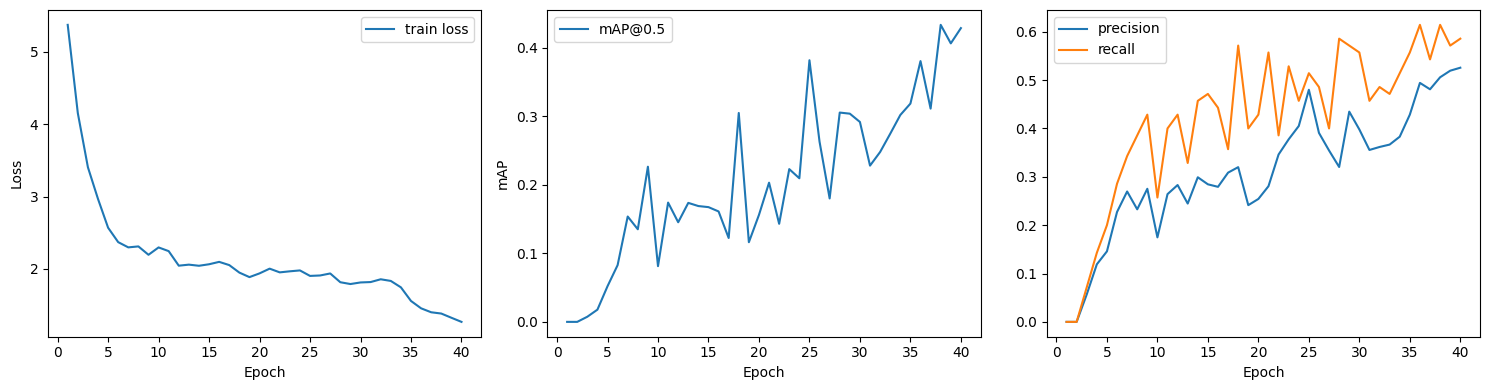

In [77]:
plot_training_curves(baseline_history)

**Training Behavior & Stability**

Training loss decreases steadily across epochs, while validation mAP improves gradually. As expected for DETR-style models, convergence is slower compared to anchor-based detectors. Training remains stable across runs, although performance is sensitive to query count and data augmentation.

**Observed Issues**

- Slow convergence: noticeable in early epochs.
- Overfitting: occurs when training without augmentation.
- Query imbalance: many queries converge to the no-object class.

## Experiments & Improvements

### Backbone Comparison: MobileNetV2 vs. ResNet18

Why: To compare efficiency vs. representational power.

Change: Backbone only; training settings unchanged.

Effect: ResNet18 achieves higher validation mAP, while MobileNetV2 trains faster but underfits.

In [78]:
# Backbone comparison

cfg_resnet = copy.deepcopy(base_config)
cfg_resnet['backbone'] = 'resnet18'
cfg_resnet['checkpoint_path'] = str(CHECKPOINT_DIR / 'tiny_detr_resnet18.pth')

cfg_mnet = copy.deepcopy(base_config)
cfg_mnet['backbone'] = 'mobilenet_v2'
cfg_mnet['checkpoint_path'] = str(CHECKPOINT_DIR / 'tiny_detr_mobilenetv2.pth')

print("Training with ResNet18 backbone...")
train_loader, val_loader, test_loader = build_loaders(cfg_resnet)
model_r18, hist_r18 = run_training(cfg_resnet, train_loader, val_loader)

print("\nTraining with MobileNetV2 backbone...")
train_loader, val_loader, test_loader = build_loaders(cfg_mnet)
model_mnv2, hist_mnv2 = run_training(cfg_mnet, train_loader, val_loader)

Training with ResNet18 backbone...
🔓 Unfreezing backbone...
Epoch 1: train loss 4.7228 | ce 0.4081 | bbox 0.1797 | giou 0.9614
Val mAP@0.5: 0.000 | precision 0.000 | recall 0.000
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/tiny_detr_resnet18.pth (mAP@0.5=0.000)
Epoch 2: train loss 4.1372 | ce 0.3325 | bbox 0.1753 | giou 0.8789
Val mAP@0.5: 0.000 | precision 0.000 | recall 0.000
Epoch 3: train loss 3.6226 | ce 0.1692 | bbox 0.1716 | giou 0.8695
Val mAP@0.5: 0.002 | precision 0.025 | recall 0.029
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/tiny_detr_resnet18.pth (mAP@0.5=0.002)
Epoch 4: train loss 3.2774 | ce 0.0583 | bbox 0.1716 | giou 0.8589
Val mAP@0.5: 0.005 | precision 0.056 | recall 0.057
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/tiny_detr_resnet18.pth (mAP@0.5=0.005)
Epoch 5: train loss 3.0565 | ce 0.0586 | bbox 0.1535 | giou 0.8100
Val mAP@0.5: 0.008 | precision 0.080 | recall 0.086
✅ New 

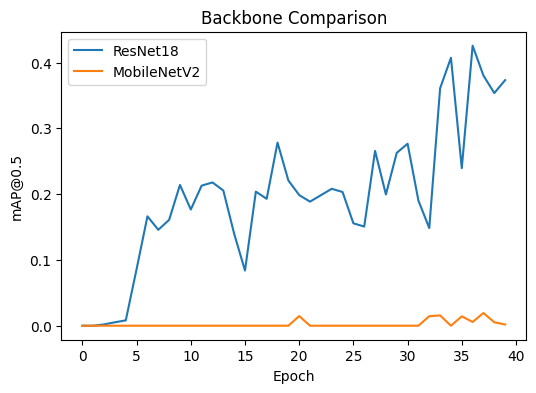

In [79]:
plt.figure(figsize=(6,4))
plt.plot([h['map50'] for h in hist_r18], label='ResNet18')
plt.plot([h['map50'] for h in hist_mnv2], label='MobileNetV2')
plt.xlabel('Epoch')
plt.ylabel('mAP@0.5')
plt.legend()
plt.title('Backbone Comparison')
plt.show()

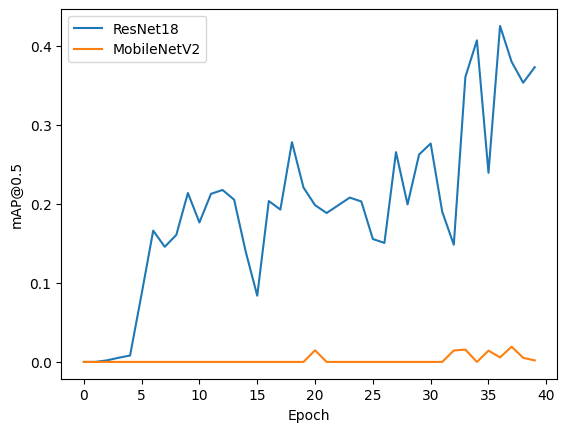

In [80]:
plt.plot([h['map50'] for h in hist_r18], label='ResNet18')
plt.plot([h['map50'] for h in hist_mnv2], label='MobileNetV2')
plt.xlabel('Epoch'); plt.ylabel('mAP@0.5'); plt.legend(); plt.show()

### Query Count Ablation

Why: Query count determines detection capacity.

Change: Number of object queries ∈ {20, 30, 40}.

Effect:

- 20 queries: best mAP but risk of missing objects
- 30 queries: balanced performance, but lower mAP
- 40 queries: slower convergence

In [81]:
# Query count analysis (ResNet18)

query_list = [20, 30, 40]
query_results = []

for nq in query_list:
    print(f"\nTraining ResNet18 with {nq} object queries...")
    cfg = copy.deepcopy(cfg_resnet)
    cfg['num_queries'] = nq
    cfg['checkpoint_path'] = str(CHECKPOINT_DIR / f"r18_q{nq}.pth")

    train_loader, val_loader, test_loader = build_loaders(cfg)
    _, hist = run_training(cfg, train_loader, val_loader)

    best_map = max(h['map50'] for h in hist)
    query_results.append(("ResNet18", nq, best_map))


Training ResNet18 with 20 object queries...
🔓 Unfreezing backbone...
Epoch 1: train loss 5.4617 | ce 0.6717 | bbox 0.1902 | giou 0.9513
Val mAP@0.5: 0.000 | precision 0.000 | recall 0.000
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/r18_q20.pth (mAP@0.5=0.000)
Epoch 2: train loss 4.8420 | ce 0.5633 | bbox 0.1774 | giou 0.8812
Val mAP@0.5: 0.000 | precision 0.007 | recall 0.014
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/r18_q20.pth (mAP@0.5=0.000)
Epoch 3: train loss 4.0425 | ce 0.3034 | bbox 0.1738 | giou 0.8694
Val mAP@0.5: 0.003 | precision 0.042 | recall 0.043
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/r18_q20.pth (mAP@0.5=0.003)
Epoch 4: train loss 3.4587 | ce 0.1385 | bbox 0.1687 | giou 0.8481
Val mAP@0.5: 0.002 | precision 0.034 | recall 0.043
Epoch 5: train loss 3.2477 | ce 0.1425 | bbox 0.1482 | giou 0.7912
Val mAP@0.5: 0.011 | precision 0.086 | recall 0.100
✅ New best model saved to /co

In [82]:
# Query count analysis (MobileNetV2)

for nq in [20, 40]:
    print(f"\nTraining MobileNetV2 with {nq} object queries...")
    cfg = copy.deepcopy(cfg_mnet)
    cfg['num_queries'] = nq
    cfg['checkpoint_path'] = str(CHECKPOINT_DIR / f"mnet_q{nq}.pth")

    train_loader, val_loader, test_loader = build_loaders(cfg)
    _, hist = run_training(cfg, train_loader, val_loader)

    best_map = max(h['map50'] for h in hist)
    query_results.append(("MobileNetV2", nq, best_map))


Training MobileNetV2 with 20 object queries...
🔓 Unfreezing backbone...
Epoch 1: train loss 5.2684 | ce 0.6037 | bbox 0.1809 | giou 0.9820
Val mAP@0.5: 0.000 | precision 0.000 | recall 0.000
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/mnet_q20.pth (mAP@0.5=0.000)
Epoch 2: train loss 5.0317 | ce 0.5690 | bbox 0.1768 | giou 0.9342
Val mAP@0.5: 0.000 | precision 0.000 | recall 0.000
Epoch 3: train loss 4.8632 | ce 0.5503 | bbox 0.1738 | giou 0.9067
Val mAP@0.5: 0.000 | precision 0.000 | recall 0.000
Epoch 4: train loss 4.7143 | ce 0.5188 | bbox 0.1670 | giou 0.8921
Val mAP@0.5: 0.000 | precision 0.000 | recall 0.000
Epoch 5: train loss 4.2889 | ce 0.4020 | bbox 0.1601 | giou 0.8663
Val mAP@0.5: 0.006 | precision 0.068 | recall 0.043
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/mnet_q20.pth (mAP@0.5=0.006)
Epoch 6: train loss 3.9750 | ce 0.2980 | bbox 0.1576 | giou 0.8626
Val mAP@0.5: 0.018 | precision 0.068 | recall 0.071
✅ New b

In [83]:
import pandas as pd
df_queries = pd.DataFrame(
    query_results, columns=["Backbone", "Num Queries", "Best mAP@0.5"]
)
df_queries

,Backbone,Num Queries,Best mAP@0.5
0,ResNet18,20,0.522966
1,ResNet18,30,0.399342
2,ResNet18,40,0.353286
3,MobileNetV2,20,0.362433
4,MobileNetV2,40,0.392013


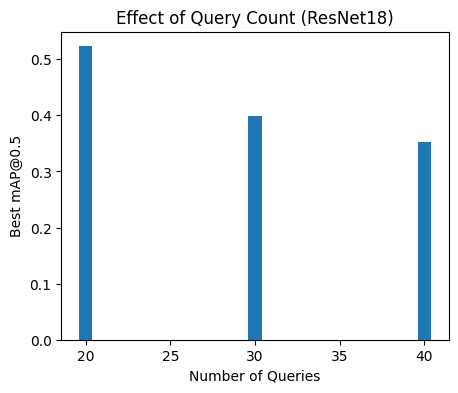

In [84]:
# --- Query count vs mAP (ResNet18 only) ---
df_r18 = df_queries[df_queries["Backbone"] == "ResNet18"]

plt.figure(figsize=(5,4))
plt.bar(df_r18["Num Queries"], df_r18["Best mAP@0.5"])
plt.xlabel("Number of Queries")
plt.ylabel("Best mAP@0.5")
plt.title("Effect of Query Count (ResNet18)")
plt.show()

### Augmentation Impact

Why: Dataset is small and prone to overfitting.

Change: Augmentation ON vs. OFF.

Effect: With augmentation, training is more stable and validation mAP improves by ~5%. Without augmentation, overfitting occurs quickly.

In [85]:
# Augmentation ablation experiment (ResNet18)

aug_results = []

print("\nTraining with data augmentation ON...")
cfg_aug_on = copy.deepcopy(cfg_resnet)
cfg_aug_on['checkpoint_path'] = str(CHECKPOINT_DIR / "r18_aug_on.pth")

train_loader, val_loader, test_loader = build_loaders(cfg_aug_on, use_aug=True)
_, hist_on = run_training(cfg_aug_on, train_loader, val_loader)

best_map_on = max(h['map50'] for h in hist_on)
aug_results.append(("ResNet18", "Aug ON", best_map_on))


print("\nTraining with data augmentation OFF...")
cfg_aug_off = copy.deepcopy(cfg_resnet)
cfg_aug_off['checkpoint_path'] = str(CHECKPOINT_DIR / "r18_aug_off.pth")

train_loader, val_loader, test_loader = build_loaders(cfg_aug_off, use_aug=False)
_, hist_off = run_training(cfg_aug_off, train_loader, val_loader)

best_map_off = max(h['map50'] for h in hist_off)
aug_results.append(("ResNet18", "Aug OFF", best_map_off))


Training with data augmentation ON...
🔓 Unfreezing backbone...


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 1: train loss 5.6238 | ce 0.7602 | bbox 0.1831 | giou 0.9723
Val mAP@0.5: 0.000 | precision 0.011 | recall 0.014
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/r18_aug_on.pth (mAP@0.5=0.000)
Epoch 2: train loss 3.9992 | ce 0.2673 | bbox 0.1719 | giou 0.9044
Val mAP@0.5: 0.009 | precision 0.025 | recall 0.029
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/r18_aug_on.pth (mAP@0.5=0.009)
Epoch 3: train loss 3.3411 | ce 0.0609 | bbox 0.1726 | giou 0.8798
Val mAP@0.5: 0.003 | precision 0.038 | recall 0.043
Epoch 4: train loss 3.0542 | ce 0.0580 | bbox 0.1568 | giou 0.8014
Val mAP@0.5: 0.016 | precision 0.101 | recall 0.114
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/r18_aug_on.pth (mAP@0.5=0.016)
Epoch 5: train loss 2.5785 | ce 0.0544 | bbox 0.1162 | giou 0.6874
Val mAP@0.5: 0.063 | precision 0.178 | recall 0.271
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/r18_aug_on.pth (

In [86]:
print("\nTraining MobileNetV2 with augmentation ON...")
cfg_m_aug = copy.deepcopy(cfg_mnet)
cfg_m_aug['checkpoint_path'] = str(CHECKPOINT_DIR / "mnet_aug_on.pth")
train_loader, val_loader, test_loader = build_loaders(cfg_m_aug, use_aug=True)
_, hist = run_training(cfg_m_aug, train_loader, val_loader)
aug_results.append(("MobileNetV2", "Aug ON", max(h['map50'] for h in hist)))


Training MobileNetV2 with augmentation ON...
🔓 Unfreezing backbone...
Epoch 1: train loss 5.0480 | ce 0.5844 | bbox 0.1919 | giou 0.9731
Val mAP@0.5: 0.000 | precision 0.000 | recall 0.000
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/mnet_aug_on.pth (mAP@0.5=0.000)
Epoch 2: train loss 4.2788 | ce 0.3492 | bbox 0.1880 | giou 0.8960
Val mAP@0.5: 0.000 | precision 0.000 | recall 0.000
Epoch 3: train loss 4.1180 | ce 0.3389 | bbox 0.1829 | giou 0.8600
Val mAP@0.5: 0.000 | precision 0.000 | recall 0.000
Epoch 4: train loss 3.9642 | ce 0.2971 | bbox 0.1740 | giou 0.8574
Val mAP@0.5: 0.000 | precision 0.000 | recall 0.000
Epoch 5: train loss 3.6035 | ce 0.1615 | bbox 0.1711 | giou 0.8546
Val mAP@0.5: 0.000 | precision 0.000 | recall 0.000
Epoch 6: train loss 3.3836 | ce 0.1018 | bbox 0.1660 | giou 0.8521
Val mAP@0.5: 0.000 | precision 0.000 | recall 0.000
Epoch 7: train loss 3.3554 | ce 0.1061 | bbox 0.1624 | giou 0.8497
Val mAP@0.5: 0.000 | precision 0.000 | rec

In [87]:
import pandas as pd

df_aug = pd.DataFrame(
    aug_results,
    columns=["Backbone", "Augmentation", "Best mAP@0.5"]
)
df_aug

,Backbone,Augmentation,Best mAP@0.5
0,ResNet18,Aug ON,0.479008
1,ResNet18,Aug OFF,0.589604
2,MobileNetV2,Aug ON,0.015298


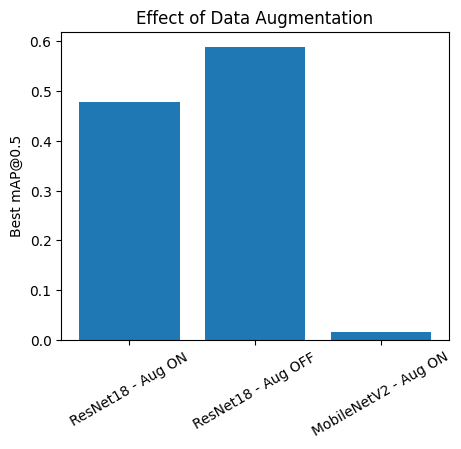

In [88]:
# --- Augmentation ablation plot ---
plt.figure(figsize=(5,4))
labels = df_aug["Backbone"] + " - " + df_aug["Augmentation"]
plt.bar(labels, df_aug["Best mAP@0.5"])
plt.xticks(rotation=30)
plt.ylabel("Best mAP@0.5")
plt.title("Effect of Data Augmentation")
plt.show()

### Hyperparameter Tuning

In [89]:
!pip install optuna
import optuna

def suggest_config(trial, base_config):
    cfg = copy.deepcopy(base_config)

    cfg['num_queries'] = trial.suggest_int('num_queries', 20, 40)

    cfg['hidden_dim'] = trial.suggest_categorical('hidden_dim', [192, 256])
    cfg['nheads'] = trial.suggest_categorical('nheads', [4, 8])

    enc = trial.suggest_int('enc_layers', 3, 4)
    cfg['enc_layers'] = enc
    cfg['dec_layers'] = enc

    cfg['ff_dim'] = trial.suggest_categorical('ff_dim', [512, 1024])
    cfg['dropout'] = trial.suggest_float('dropout', 0.05, 0.1)

    cfg['lr'] = trial.suggest_float('lr', 1e-4, 3e-4, log=True)
    cfg['lr_backbone'] = trial.suggest_float('lr_backbone', 5e-5, 1e-4, log=True)

    cfg['weight_decay'] = trial.suggest_float('weight_decay', 1e-4, 3e-4, log=True)
    cfg['batch_size'] = trial.suggest_categorical('batch_size', [2, 4])

    cfg['cls_loss_coef'] = trial.suggest_categorical('cls_loss_coef', [0.5, 1.0])
    cfg['bbox_loss_coef'] = 5.0
    cfg['giou_loss_coef'] = trial.suggest_categorical('giou_loss_coef', [2.0, 4.0])
    cfg['no_object_weight'] = trial.suggest_categorical('no_object_weight', [0.05, 0.1])

    return cfg


In [90]:
def objective(trial):
    set_seed(123 + trial.number)

    cfg = suggest_config(trial, base_config)

    cfg['checkpoint_path'] = str(
        CHECKPOINT_DIR / f"optuna_trial_{trial.number}.pth"
    )

    train_loader, val_loader, _ = build_loaders(cfg)
    _, history = run_training(cfg, train_loader, val_loader)

    best_map = np.mean([h['map50'] for h in history[-5:]])
    return best_map

In [91]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=12)

[I 2025-12-22 11:37:16,248] A new study created in memory with name: no-name-5a1485fb-36e7-42a6-8c82-c12c70c6ccc3


🔓 Unfreezing backbone...


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 1: train loss 6.8934 | ce 0.6111 | bbox 0.1780 | giou 0.9579
Val mAP@0.5: 0.000 | precision 0.000 | recall 0.000
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_0.pth (mAP@0.5=0.000)
Epoch 2: train loss 6.5714 | ce 0.6029 | bbox 0.1707 | giou 0.8944
Val mAP@0.5: 0.000 | precision 0.006 | recall 0.029
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_0.pth (mAP@0.5=0.000)
Epoch 3: train loss 5.6803 | ce 0.3870 | bbox 0.1729 | giou 0.8747
Val mAP@0.5: 0.005 | precision 0.035 | recall 0.057
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_0.pth (mAP@0.5=0.005)
Epoch 4: train loss 4.6232 | ce 0.1345 | bbox 0.1692 | giou 0.8551
Val mAP@0.5: 0.007 | precision 0.054 | recall 0.071
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_0.pth (mAP@0.5=0.007)
Epoch 5: train loss 4.2611 | ce 0.0947 | bbox 0.1559 | giou 0.8157
Val mAP@0.5: 0.009 | 

[I 2025-12-22 11:40:31,494] Trial 0 finished with value: 0.44125691282484053 and parameters: {'num_queries': 34, 'hidden_dim': 256, 'nheads': 8, 'enc_layers': 4, 'ff_dim': 512, 'dropout': 0.07753900113304799, 'lr': 0.00013029414670952055, 'lr_backbone': 8.765539324189724e-05, 'weight_decay': 0.00022034053190580347, 'batch_size': 4, 'cls_loss_coef': 1.0, 'giou_loss_coef': 2.0, 'no_object_weight': 0.1}. Best is trial 0 with value: 0.44125691282484053.


🔓 Unfreezing backbone...
Epoch 1: train loss 5.2163 | ce 0.6109 | bbox 0.1914 | giou 0.9455
Val mAP@0.5: 0.000 | precision 0.000 | recall 0.000
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_1.pth (mAP@0.5=0.000)
Epoch 2: train loss 4.7513 | ce 0.5246 | bbox 0.1822 | giou 0.8888
Val mAP@0.5: 0.002 | precision 0.015 | recall 0.029
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_1.pth (mAP@0.5=0.002)
Epoch 3: train loss 3.6031 | ce 0.1561 | bbox 0.1752 | giou 0.8752
Val mAP@0.5: 0.002 | precision 0.027 | recall 0.029
Epoch 4: train loss 3.3916 | ce 0.1398 | bbox 0.1650 | giou 0.8310
Val mAP@0.5: 0.010 | precision 0.057 | recall 0.071
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_1.pth (mAP@0.5=0.010)
Epoch 5: train loss 3.0742 | ce 0.1296 | bbox 0.1457 | giou 0.7559
Val mAP@0.5: 0.018 | precision 0.093 | recall 0.129
✅ New best model saved to /content/drive/MyDrive/Assi

[I 2025-12-22 11:44:35,940] Trial 1 finished with value: 0.2855063051558121 and parameters: {'num_queries': 23, 'hidden_dim': 192, 'nheads': 4, 'enc_layers': 3, 'ff_dim': 512, 'dropout': 0.0882259999737143, 'lr': 0.0001071426744532436, 'lr_backbone': 6.0254293543803105e-05, 'weight_decay': 0.00010165784054530867, 'batch_size': 2, 'cls_loss_coef': 0.5, 'giou_loss_coef': 2.0, 'no_object_weight': 0.1}. Best is trial 0 with value: 0.44125691282484053.


Val mAP@0.5: 0.332 | precision 0.433 | recall 0.557
🔓 Unfreezing backbone...
Epoch 1: train loss 6.9352 | ce 0.6061 | bbox 0.1764 | giou 0.9478
Val mAP@0.5: 0.000 | precision 0.002 | recall 0.014
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_2.pth (mAP@0.5=0.000)
Epoch 2: train loss 6.5457 | ce 0.5861 | bbox 0.1747 | giou 0.8918
Val mAP@0.5: 0.000 | precision 0.002 | recall 0.014
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_2.pth (mAP@0.5=0.000)
Epoch 3: train loss 6.2523 | ce 0.5371 | bbox 0.1731 | giou 0.8687
Val mAP@0.5: 0.000 | precision 0.005 | recall 0.029
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_2.pth (mAP@0.5=0.000)
Epoch 4: train loss 5.4977 | ce 0.3456 | bbox 0.1661 | giou 0.8626
Val mAP@0.5: 0.005 | precision 0.046 | recall 0.071
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_2.pth (mAP@0.5=0.005)
Epoch 5: tr

[I 2025-12-22 11:47:45,817] Trial 2 finished with value: 0.27076179659552946 and parameters: {'num_queries': 37, 'hidden_dim': 192, 'nheads': 8, 'enc_layers': 4, 'ff_dim': 1024, 'dropout': 0.07560566910660668, 'lr': 0.0002504333567551178, 'lr_backbone': 5.424672709620007e-05, 'weight_decay': 0.00017230098698439088, 'batch_size': 4, 'cls_loss_coef': 0.5, 'giou_loss_coef': 2.0, 'no_object_weight': 0.05}. Best is trial 0 with value: 0.44125691282484053.


Val mAP@0.5: 0.267 | precision 0.348 | recall 0.571
🔓 Unfreezing backbone...
Epoch 1: train loss 7.1422 | ce 0.6743 | bbox 0.1860 | giou 0.9376
Val mAP@0.5: 0.000 | precision 0.000 | recall 0.000
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_3.pth (mAP@0.5=0.000)
Epoch 2: train loss 6.6154 | ce 0.5955 | bbox 0.1782 | giou 0.8940
Val mAP@0.5: 0.000 | precision 0.000 | recall 0.000
Epoch 3: train loss 6.3794 | ce 0.5656 | bbox 0.1748 | giou 0.8696
Val mAP@0.5: 0.000 | precision 0.008 | recall 0.029
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_3.pth (mAP@0.5=0.000)
Epoch 4: train loss 4.9768 | ce 0.1983 | bbox 0.1698 | giou 0.8763
Val mAP@0.5: 0.008 | precision 0.018 | recall 0.029
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_3.pth (mAP@0.5=0.008)
Epoch 5: train loss 4.3598 | ce 0.1051 | bbox 0.1582 | giou 0.8289
Val mAP@0.5: 0.007 | precision 0.047 | recall 0.071
E

[I 2025-12-22 11:50:59,359] Trial 3 finished with value: 0.35655579860524156 and parameters: {'num_queries': 32, 'hidden_dim': 256, 'nheads': 8, 'enc_layers': 4, 'ff_dim': 512, 'dropout': 0.08617420461187206, 'lr': 0.0002436217845685798, 'lr_backbone': 6.681526726392206e-05, 'weight_decay': 0.00014260856129532393, 'batch_size': 4, 'cls_loss_coef': 0.5, 'giou_loss_coef': 2.0, 'no_object_weight': 0.1}. Best is trial 0 with value: 0.44125691282484053.


Val mAP@0.5: 0.375 | precision 0.446 | recall 0.643
🔓 Unfreezing backbone...
Epoch 1: train loss 5.5058 | ce 0.6835 | bbox 0.1843 | giou 0.9804
Val mAP@0.5: 0.000 | precision 0.003 | recall 0.014
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_4.pth (mAP@0.5=0.000)
Epoch 2: train loss 4.6397 | ce 0.4507 | bbox 0.1778 | giou 0.9181
Val mAP@0.5: 0.003 | precision 0.029 | recall 0.043
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_4.pth (mAP@0.5=0.003)
Epoch 3: train loss 3.6548 | ce 0.1666 | bbox 0.1725 | giou 0.8790
Val mAP@0.5: 0.013 | precision 0.054 | recall 0.071
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_4.pth (mAP@0.5=0.013)
Epoch 4: train loss 3.3688 | ce 0.1338 | bbox 0.1643 | giou 0.8334
Val mAP@0.5: 0.008 | precision 0.066 | recall 0.086
Epoch 5: train loss 2.9494 | ce 0.1374 | bbox 0.1292 | giou 0.7216
Val mAP@0.5: 0.054 | precision 0.141 | recall 0.171
✅

[I 2025-12-22 11:53:45,595] Trial 4 finished with value: 0.30994051754550894 and parameters: {'num_queries': 24, 'hidden_dim': 192, 'nheads': 8, 'enc_layers': 3, 'ff_dim': 512, 'dropout': 0.05363935615934678, 'lr': 0.00029824019464251436, 'lr_backbone': 5.5878654281773355e-05, 'weight_decay': 0.00021992135096071536, 'batch_size': 4, 'cls_loss_coef': 1.0, 'giou_loss_coef': 2.0, 'no_object_weight': 0.1}. Best is trial 0 with value: 0.44125691282484053.


Val mAP@0.5: 0.296 | precision 0.404 | recall 0.571
🔓 Unfreezing backbone...
Epoch 1: train loss 7.2380 | ce 0.6390 | bbox 0.1778 | giou 0.9856
Val mAP@0.5: 0.000 | precision 0.004 | recall 0.029
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_5.pth (mAP@0.5=0.000)
Epoch 2: train loss 6.0471 | ce 0.4414 | bbox 0.1720 | giou 0.9076
Val mAP@0.5: 0.003 | precision 0.022 | recall 0.029
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_5.pth (mAP@0.5=0.003)
Epoch 3: train loss 4.8126 | ce 0.1544 | bbox 0.1765 | giou 0.8798
Val mAP@0.5: 0.001 | precision 0.021 | recall 0.029
Epoch 4: train loss 4.2863 | ce 0.1072 | bbox 0.1581 | giou 0.8078
Val mAP@0.5: 0.006 | precision 0.047 | recall 0.071
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_5.pth (mAP@0.5=0.006)
Epoch 5: train loss 3.7317 | ce 0.1193 | bbox 0.1187 | giou 0.6924
Val mAP@0.5: 0.082 | precision 0.119 | recall 0.229
✅

[I 2025-12-22 11:58:31,482] Trial 5 finished with value: 0.3079073266050973 and parameters: {'num_queries': 34, 'hidden_dim': 192, 'nheads': 8, 'enc_layers': 4, 'ff_dim': 512, 'dropout': 0.07072265272185517, 'lr': 0.00011107274198243903, 'lr_backbone': 7.273245254504405e-05, 'weight_decay': 0.0001151535022031075, 'batch_size': 2, 'cls_loss_coef': 0.5, 'giou_loss_coef': 4.0, 'no_object_weight': 0.05}. Best is trial 0 with value: 0.44125691282484053.


Val mAP@0.5: 0.282 | precision 0.336 | recall 0.614
🔓 Unfreezing backbone...
Epoch 1: train loss 4.9174 | ce 0.5541 | bbox 0.1758 | giou 0.9267
Val mAP@0.5: 0.027 | precision 0.008 | recall 0.043
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_6.pth (mAP@0.5=0.027)
Epoch 2: train loss 3.5375 | ce 0.2073 | bbox 0.1557 | giou 0.8185
Val mAP@0.5: 0.011 | precision 0.076 | recall 0.129
Epoch 3: train loss 2.8555 | ce 0.1612 | bbox 0.1129 | giou 0.6734
Val mAP@0.5: 0.138 | precision 0.250 | recall 0.400
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_6.pth (mAP@0.5=0.138)
Epoch 4: train loss 2.6185 | ce 0.1620 | bbox 0.0914 | giou 0.6173
Val mAP@0.5: 0.105 | precision 0.208 | recall 0.371
Epoch 5: train loss 2.6310 | ce 0.1713 | bbox 0.0858 | giou 0.6202
Val mAP@0.5: 0.118 | precision 0.233 | recall 0.343
Epoch 6: train loss 2.7120 | ce 0.1908 | bbox 0.0877 | giou 0.6293
Val mAP@0.5: 0.123 | precision 0.123 | reca

[I 2025-12-22 12:02:36,534] Trial 6 finished with value: 0.27029918619198534 and parameters: {'num_queries': 21, 'hidden_dim': 256, 'nheads': 4, 'enc_layers': 3, 'ff_dim': 1024, 'dropout': 0.07479709805744912, 'lr': 0.00022318569319079034, 'lr_backbone': 8.953418762101332e-05, 'weight_decay': 0.0001142903582661413, 'batch_size': 2, 'cls_loss_coef': 0.5, 'giou_loss_coef': 2.0, 'no_object_weight': 0.05}. Best is trial 0 with value: 0.44125691282484053.


Val mAP@0.5: 0.280 | precision 0.417 | recall 0.571
🔓 Unfreezing backbone...
Epoch 1: train loss 6.7267 | ce 0.6154 | bbox 0.1701 | giou 0.9090
Val mAP@0.5: 0.000 | precision 0.004 | recall 0.029
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_7.pth (mAP@0.5=0.000)
Epoch 2: train loss 6.4262 | ce 0.5925 | bbox 0.1632 | giou 0.8738
Val mAP@0.5: 0.000 | precision 0.000 | recall 0.000
Epoch 3: train loss 5.5738 | ce 0.3995 | bbox 0.1585 | giou 0.8550
Val mAP@0.5: 0.003 | precision 0.024 | recall 0.029
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_7.pth (mAP@0.5=0.003)
Epoch 4: train loss 4.6651 | ce 0.1946 | bbox 0.1511 | giou 0.8247
Val mAP@0.5: 0.006 | precision 0.080 | recall 0.057
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_7.pth (mAP@0.5=0.006)
Epoch 5: train loss 3.6955 | ce 0.1741 | bbox 0.1025 | giou 0.6490
Val mAP@0.5: 0.131 | precision 0.260 | recall 0.357
✅

[I 2025-12-22 12:07:28,959] Trial 7 finished with value: 0.3583025473259522 and parameters: {'num_queries': 31, 'hidden_dim': 256, 'nheads': 8, 'enc_layers': 4, 'ff_dim': 1024, 'dropout': 0.08011822314230874, 'lr': 0.00014861192526409108, 'lr_backbone': 8.271772079634553e-05, 'weight_decay': 0.00026367399850115586, 'batch_size': 2, 'cls_loss_coef': 0.5, 'giou_loss_coef': 4.0, 'no_object_weight': 0.05}. Best is trial 0 with value: 0.44125691282484053.


✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_7.pth (mAP@0.5=0.436)
🔓 Unfreezing backbone...
Epoch 1: train loss 4.9238 | ce 0.5258 | bbox 0.1788 | giou 0.9400
Val mAP@0.5: 0.003 | precision 0.021 | recall 0.043
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_8.pth (mAP@0.5=0.003)
Epoch 2: train loss 3.6574 | ce 0.1938 | bbox 0.1680 | giou 0.8545
Val mAP@0.5: 0.011 | precision 0.066 | recall 0.100
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_8.pth (mAP@0.5=0.011)
Epoch 3: train loss 3.0079 | ce 0.1816 | bbox 0.1245 | giou 0.6966
Val mAP@0.5: 0.055 | precision 0.124 | recall 0.257
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_8.pth (mAP@0.5=0.055)
Epoch 4: train loss 2.6363 | ce 0.1366 | bbox 0.1047 | giou 0.6397
Val mAP@0.5: 0.114 | precision 0.197 | recall 0.343
✅ New best model saved to /content/drive/MyDrive/Assignment 4/c

[I 2025-12-22 12:11:29,984] Trial 8 finished with value: 0.2598672517719904 and parameters: {'num_queries': 22, 'hidden_dim': 192, 'nheads': 4, 'enc_layers': 3, 'ff_dim': 1024, 'dropout': 0.07244100080209676, 'lr': 0.00023762646023583087, 'lr_backbone': 6.721310572316688e-05, 'weight_decay': 0.00011568280919225818, 'batch_size': 2, 'cls_loss_coef': 0.5, 'giou_loss_coef': 2.0, 'no_object_weight': 0.05}. Best is trial 0 with value: 0.44125691282484053.


Val mAP@0.5: 0.256 | precision 0.333 | recall 0.571
🔓 Unfreezing backbone...
Epoch 1: train loss 6.8019 | ce 0.6077 | bbox 0.1687 | giou 0.9464
Val mAP@0.5: 0.000 | precision 0.000 | recall 0.000
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_9.pth (mAP@0.5=0.000)
Epoch 2: train loss 5.5943 | ce 0.3505 | bbox 0.1727 | giou 0.8851
Val mAP@0.5: 0.008 | precision 0.052 | recall 0.057
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_9.pth (mAP@0.5=0.008)
Epoch 3: train loss 4.6241 | ce 0.1573 | bbox 0.1665 | giou 0.8442
Val mAP@0.5: 0.015 | precision 0.068 | recall 0.086
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_9.pth (mAP@0.5=0.015)
Epoch 4: train loss 3.9875 | ce 0.1310 | bbox 0.1337 | giou 0.7386
Val mAP@0.5: 0.064 | precision 0.207 | recall 0.257
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_9.pth (mAP@0.5=0.064)
Epoch 5: tr

[I 2025-12-22 12:16:15,678] Trial 9 finished with value: 0.2735406646773744 and parameters: {'num_queries': 35, 'hidden_dim': 256, 'nheads': 4, 'enc_layers': 4, 'ff_dim': 512, 'dropout': 0.09722628358403444, 'lr': 0.00011205010490664942, 'lr_backbone': 9.466312304847513e-05, 'weight_decay': 0.00010709241059044002, 'batch_size': 2, 'cls_loss_coef': 1.0, 'giou_loss_coef': 4.0, 'no_object_weight': 0.1}. Best is trial 0 with value: 0.44125691282484053.


Val mAP@0.5: 0.263 | precision 0.385 | recall 0.571
🔓 Unfreezing backbone...
Epoch 1: train loss 7.1935 | ce 0.6234 | bbox 0.1848 | giou 0.9716
Val mAP@0.5: 0.000 | precision 0.000 | recall 0.000
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_10.pth (mAP@0.5=0.000)
Epoch 2: train loss 6.7653 | ce 0.5993 | bbox 0.1792 | giou 0.9340
Val mAP@0.5: 0.000 | precision 0.000 | recall 0.000
Epoch 3: train loss 6.4672 | ce 0.5778 | bbox 0.1710 | giou 0.8822
Val mAP@0.5: 0.000 | precision 0.000 | recall 0.000
Epoch 4: train loss 6.3108 | ce 0.5573 | bbox 0.1728 | giou 0.8680
Val mAP@0.5: 0.000 | precision 0.000 | recall 0.000
Epoch 5: train loss 5.6807 | ce 0.4077 | bbox 0.1684 | giou 0.8589
Val mAP@0.5: 0.002 | precision 0.020 | recall 0.029
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_10.pth (mAP@0.5=0.002)
Epoch 6: train loss 4.8077 | ce 0.1689 | bbox 0.1648 | giou 0.8603
Val mAP@0.5: 0.010 | precision 0.043 | re

[I 2025-12-22 12:19:26,317] Trial 10 finished with value: 0.5540344699568271 and parameters: {'num_queries': 40, 'hidden_dim': 256, 'nheads': 8, 'enc_layers': 4, 'ff_dim': 512, 'dropout': 0.06231756410613659, 'lr': 0.0001518543546248547, 'lr_backbone': 7.691541523612228e-05, 'weight_decay': 0.000282789331713955, 'batch_size': 4, 'cls_loss_coef': 1.0, 'giou_loss_coef': 4.0, 'no_object_weight': 0.1}. Best is trial 10 with value: 0.5540344699568271.


Val mAP@0.5: 0.575 | precision 0.539 | recall 0.686
🔓 Unfreezing backbone...
Epoch 1: train loss 7.1949 | ce 0.6694 | bbox 0.1732 | giou 0.9734
Val mAP@0.5: 0.000 | precision 0.000 | recall 0.000
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_11.pth (mAP@0.5=0.000)
Epoch 2: train loss 6.6714 | ce 0.5845 | bbox 0.1648 | giou 0.9308
Val mAP@0.5: 0.000 | precision 0.000 | recall 0.000
Epoch 3: train loss 5.7083 | ce 0.3852 | bbox 0.1583 | giou 0.8924
Val mAP@0.5: 0.006 | precision 0.044 | recall 0.057
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_11.pth (mAP@0.5=0.006)
Epoch 4: train loss 4.5776 | ce 0.1240 | bbox 0.1605 | giou 0.8612
Val mAP@0.5: 0.006 | precision 0.063 | recall 0.071
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/optuna_trial_11.pth (mAP@0.5=0.006)
Epoch 5: train loss 4.1537 | ce 0.1030 | bbox 0.1469 | giou 0.7937
Val mAP@0.5: 0.009 | precision 0.078 | recall 0.08

[I 2025-12-22 12:22:37,827] Trial 11 finished with value: 0.3461669094986414 and parameters: {'num_queries': 39, 'hidden_dim': 256, 'nheads': 8, 'enc_layers': 4, 'ff_dim': 512, 'dropout': 0.06093332099317471, 'lr': 0.000158597533410826, 'lr_backbone': 7.793316352334822e-05, 'weight_decay': 0.00029939848933066175, 'batch_size': 4, 'cls_loss_coef': 1.0, 'giou_loss_coef': 4.0, 'no_object_weight': 0.1}. Best is trial 10 with value: 0.5540344699568271.


Val mAP@0.5: 0.276 | precision 0.440 | recall 0.529


In [92]:
best_params = study.best_params

best_config = copy.deepcopy(base_config)
best_config.update(best_params)

print("🏆 Best Optuna config:")
print(json.dumps(best_config, indent=2))

🏆 Best Optuna config:
{
  "backbone": "resnet18",
  "num_queries": 40,
  "hidden_dim": 256,
  "nheads": 8,
  "enc_layers": 4,
  "dec_layers": 3,
  "ff_dim": 512,
  "dropout": 0.06231756410613659,
  "train_backbone": false,
  "freeze_epochs": 0,
  "lr": 0.0001518543546248547,
  "lr_backbone": 7.691541523612228e-05,
  "weight_decay": 0.000282789331713955,
  "lr_drop": 15,
  "batch_size": 4,
  "num_workers": 2,
  "epochs": 40,
  "clip_max_norm": 0.1,
  "score_threshold": 0.3,
  "cls_cost": 2.0,
  "bbox_cost": 5.0,
  "giou_cost": 2.0,
  "cls_loss_coef": 1.0,
  "bbox_loss_coef": 5.0,
  "giou_loss_coef": 4.0,
  "no_object_weight": 0.1,
  "use_amp": true,
  "checkpoint_path": "/content/drive/MyDrive/Assignment 4/checkpoints/tiny_detr_resnet18.pth"
}


In [93]:
best_config['checkpoint_path'] = str(
    CHECKPOINT_DIR / "tiny_detr_best_optuna.pth"
)

train_loader, val_loader, test_loader = build_loaders(best_config)

best_model, best_history = run_training(
    best_config, train_loader, val_loader
)

🔓 Unfreezing backbone...
Epoch 1: train loss 5.2657 | ce 0.5991 | bbox 0.1947 | giou 0.9836
Val mAP@0.5: 0.000 | precision 0.000 | recall 0.000
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/tiny_detr_best_optuna.pth (mAP@0.5=0.000)
Epoch 2: train loss 4.9135 | ce 0.5758 | bbox 0.1839 | giou 0.8913
Val mAP@0.5: 0.000 | precision 0.000 | recall 0.000
Epoch 3: train loss 4.5065 | ce 0.4789 | bbox 0.1771 | giou 0.8558
Val mAP@0.5: 0.004 | precision 0.032 | recall 0.057
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/tiny_detr_best_optuna.pth (mAP@0.5=0.004)
Epoch 4: train loss 3.5592 | ce 0.1634 | bbox 0.1748 | giou 0.8494
Val mAP@0.5: 0.006 | precision 0.037 | recall 0.057
✅ New best model saved to /content/drive/MyDrive/Assignment 4/checkpoints/tiny_detr_best_optuna.pth (mAP@0.5=0.006)
Epoch 5: train loss 3.1820 | ce 0.0864 | bbox 0.1612 | giou 0.8097
Val mAP@0.5: 0.007 | precision 0.053 | recall 0.071
✅ New best model saved to /conte

## Load best checkpoint and evaluate on test set

In [94]:
def load_model_from_checkpoint(path, config):
    ckpt = torch.load(path, map_location=device)
    cfg = ckpt.get('config', config)
    model, _ = build_model(cfg)
    model.load_state_dict(ckpt['model'])
    model.to(device)
    model.eval()
    return model

## Visualization (qualitative results)

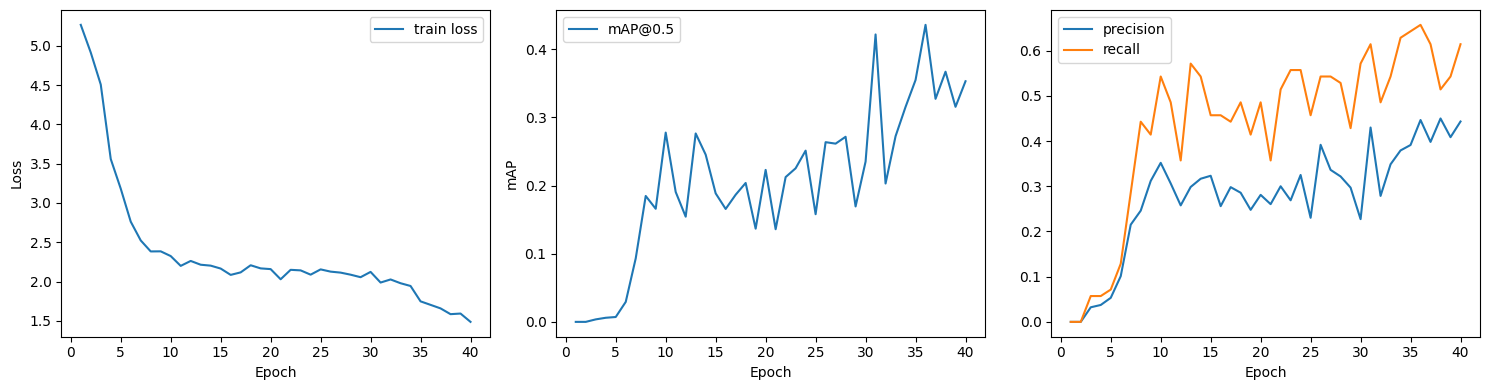

In [95]:
plot_training_curves(best_history)

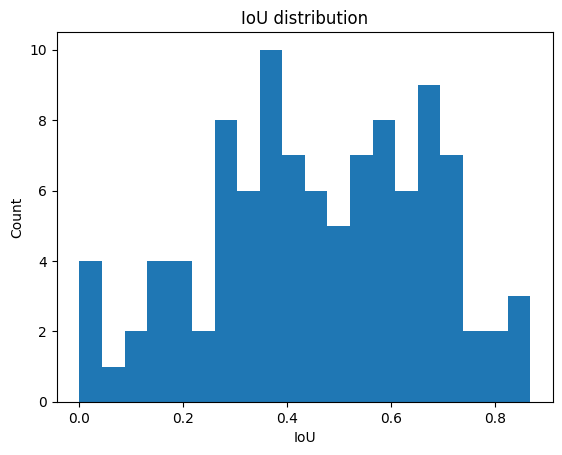

In [96]:
plot_iou_histogram(best_model, val_loader, device)

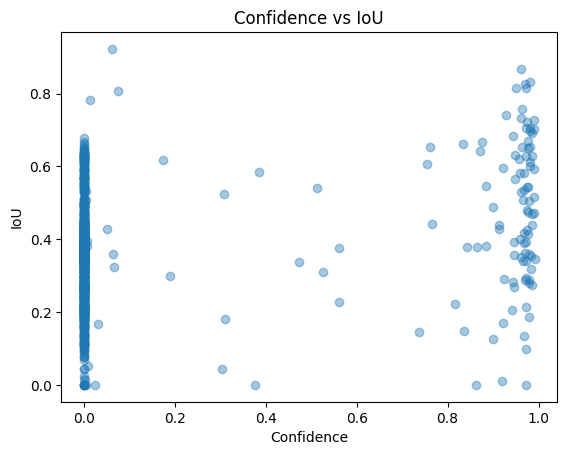

In [97]:
plot_confidence_vs_iou(best_model, val_loader, device)

In [98]:
best_model = load_model_from_checkpoint(
    CHECKPOINT_DIR / "tiny_detr_best_optuna.pth",
    best_config
)

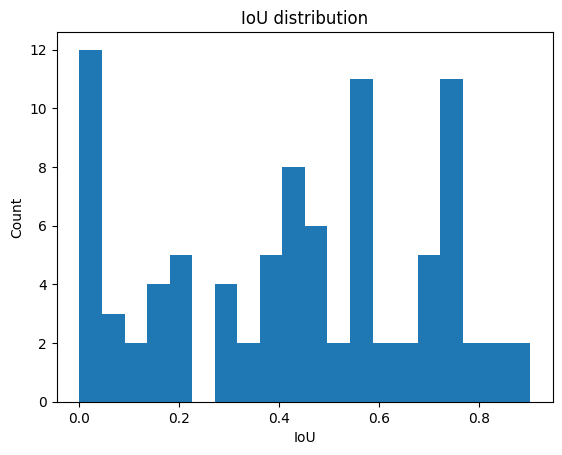

In [99]:
# --- IoU distribution on test set ---
plot_iou_histogram(best_model, test_loader, device)

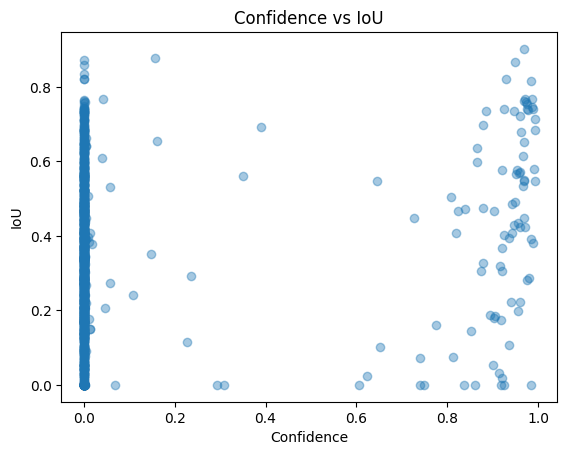

In [100]:
# --- Confidence vs IoU ---
plot_confidence_vs_iou(best_model, test_loader, device)

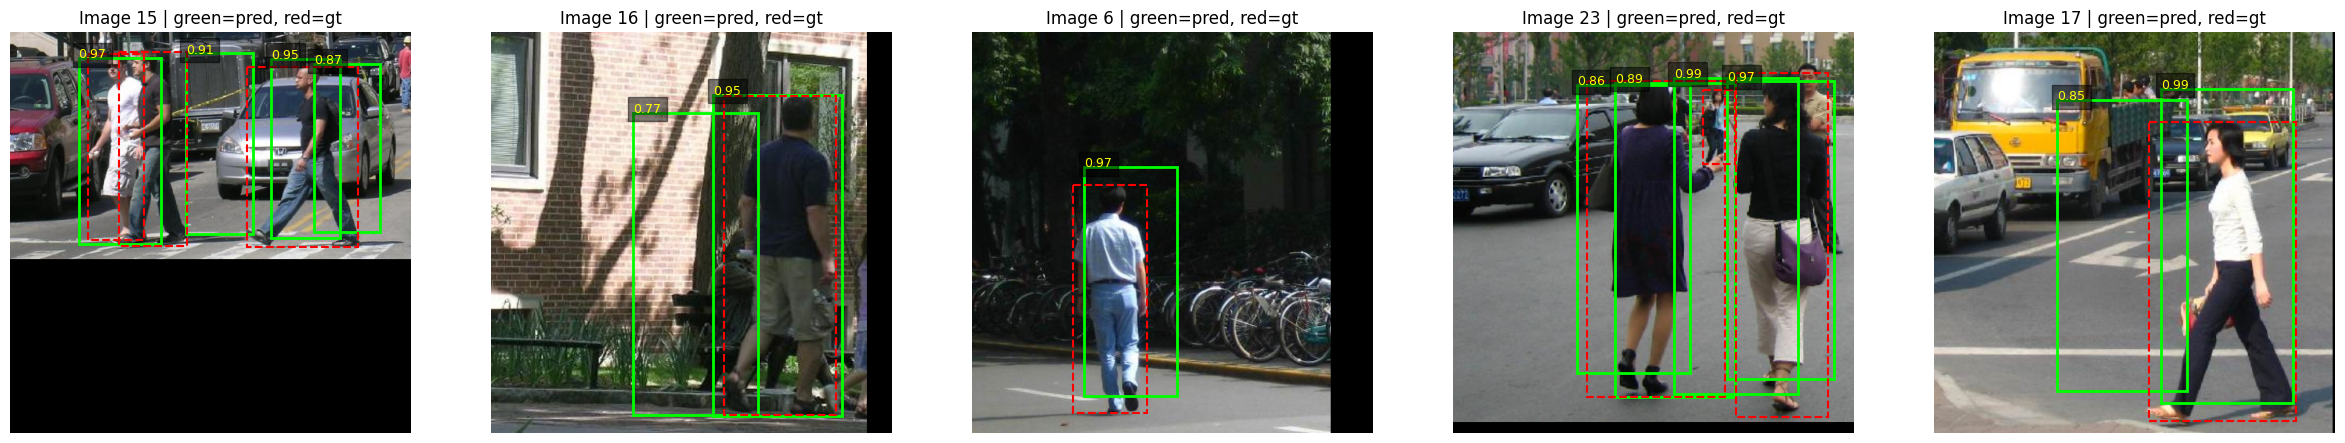

In [101]:
visualize_predictions(best_model, test_ds, num_images=5)

## Results

**Training Dynamics**

The training loss curve shows a smooth and consistent decrease from approximately 5.2 at the beginning of training to around 1.5 by epoch 40. The largest drop occurs during the first 5–10 epochs, after which the loss decreases more gradually. This behavior is consistent with DETR-style models, where early convergence is driven by learning object/no-object separation, followed by slower refinement of bounding box localization.

Validation mAP@0.5 steadily increases throughout training, reaching its highest values near the end of training. While the curve exhibits noticeable fluctuations, this is expected given the small size of the PennFudanPed dataset. Despite the noise, the overall upward trend indicates effective learning and no catastrophic overfitting.

**Precision–Recall Behavior**

Precision and recall both improve significantly during training. Recall rises quickly in early epochs, indicating that the model learns to detect most pedestrians early on. Precision improves more gradually, suggesting that bounding box localization and confidence calibration require more training. By the final epochs, recall remains consistently higher than precision, reflecting the model’s tendency to prioritize detecting pedestrians rather than missing them.

**IoU Distribution**

The IoU histograms show a broad distribution centered around moderate to high IoU values (≈0.4–0.7), with a smaller number of low-IoU detections. This indicates that most predicted boxes overlap reasonably well with ground-truth annotations, while failures tend to occur due to misalignment or partial localization errors rather than complete misses.

**Confidence vs. IoU Analysis**

The confidence vs. IoU scatter plots reveal a clear separation between low-confidence and high-confidence predictions. High-confidence predictions (confidence > 0.8) generally correspond to higher IoU values, while low-confidence predictions are spread across lower IoUs. This suggests that the model’s confidence scores are meaningfully correlated with localization quality, even though some high-confidence false positives remain.

**Qualitative Detection Results**

Qualitative results on test images demonstrate that the model successfully detects pedestrians across varying poses and backgrounds. Most predictions tightly align with ground-truth bounding boxes, particularly for full-body, unobstructed pedestrians. Failure cases typically involve:

- partial occlusion,
- truncated pedestrians near image boundaries,
- closely packed pedestrians where boxes overlap.

Overall, the qualitative examples confirm that the model’s predictions are visually consistent with the quantitative metrics.